## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the datasets

In [2]:
train = pd.read_parquet("..\data\\train.parquet")
test = pd.read_parquet("..\data\\final_test.parquet")

# We drop bike count, as it can't be used for training
train.drop(columns=["bike_count"], inplace=True)

In [3]:
train

,counter_id,counter_name,site_id,site_name,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2020-09-01 04:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2020-09-01 15:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2020-09-01 18:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2.302585
...,...,...,...,...,...,...,...,...,...,...,...
929175,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,2021-09-09 06:00:00,2020-11-29,"48.83977,2.30198",Y2H20114504,48.839770,2.301980,6.100319
929178,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,2021-09-09 10:00:00,2020-11-29,"48.83977,2.30198",Y2H20114504,48.839770,2.301980,4.983607
929181,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,2021-09-09 15:00:00,2020-11-29,"48.83977,2.30198",Y2H20114504,48.839770,2.301980,5.389072
929184,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,2021-09-09 22:00:00,2020-11-29,"48.83977,2.30198",Y2H20114504,48.839770,2.301980,3.091042


In [4]:
X = train.drop(columns=["log_bike_count"])
y = train["log_bike_count"]

In [5]:
def train_test_split_temporal(X, y, delta_threshold="30 days"):
    
    cutoff_date = X["date"].max() - pd.Timedelta(delta_threshold)
    mask = (X["date"] <= cutoff_date)
    X_train, X_valid = X.loc[mask], X.loc[~mask]
    y_train, y_valid = y[mask], y[~mask]

    return X_train, y_train, X_valid, y_valid

X_train, y_train, X_valid, y_valid = train_test_split_temporal(X, y)

## Prediction function formatter

The following function is used to format the prediction to match what is expected for a kaggle submission.

In [6]:
def kaggle_prediction(model, file_path, test_set=test):
    """
    Return a .csv file for kaggle submission (predictions of the test dataset)
    Parameters:
        - model : a fitted sklearn model object
        - test_set : the dataset to predict log_bike_count on 
    Output:
        - file.csv : a .csv file to submit to kaggle 
    """

    y_pred = model.predict(test_set)
    y_pred_df = pd.DataFrame(y_pred, columns=["log_bike_count"])
    y_pred_df.index.name = "Id"

    y_pred_df.to_csv(file_path)

    return None

## Pipeline creator

This section is to standardize the fitting of new models to streamline the process.

In [7]:
from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.model_selection import cross_val_score

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 496827 entries, 48321 to 929187
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 496827 non-null  category      
 1   counter_name               496827 non-null  category      
 2   site_id                    496827 non-null  int64         
 3   site_name                  496827 non-null  category      
 4   date                       496827 non-null  datetime64[us]
 5   counter_installation_date  496827 non-null  datetime64[us]
 6   coordinates                496827 non-null  category      
 7   counter_technical_id       496827 non-null  category      
 8   latitude                   496827 non-null  float64       
 9   longitude                  496827 non-null  float64       
 10  log_bike_count             496827 non-null  float64       
dtypes: category(5), datetime64[us](2), float64(3), int64(

We will drop the `coordinates` column, as it is redundant with `latitude` and `longitude`. We will also drop `counter_id` and `site_id`, as they are redundant with `counter_name` and `site_name` respectively. To integrate this in a pipeline, we wrap it in a `FunctionTransformer`:

In [9]:
columns_to_drop =  ["counter_name", "counter_id", "site_name", "site_id", "coordinates", "counter_technical_id", "counter_installation_date"]

def drop_columns(X, columns_to_drop=columns_to_drop):
    return X.drop(columns=columns_to_drop)

# column_dropper = FunctionTransformer(lambda X: drop_columns(X, columns_to_drop=columns_to_drop), validate=False)
column_dropper = FunctionTransformer(drop_columns, validate=False)

In [10]:
def encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the "date" columns
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["day"] = X["date"].dt.day
    X["weekday"] = X["date"].dt.weekday
    X["hour"] = X["date"].dt.hour

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])

date_encoder = FunctionTransformer(encode_dates, validate=False)
date_cols = encode_dates(X[["date"]]).columns.tolist()

We also manually encode vacation dates, as well as Covid curfew days: 

In [11]:
vacation_paris_2020 = [
    ("2020-10-17", "2020-11-01"),  
    ("2020-12-19", "2021-01-03"),  
    ("2021-02-13", "2021-02-28"),  
    ("2021-04-17", "2021-05-02"), 
    ("2021-07-06", "2021-08-31"), 
]

vacation_paris_2020 = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in vacation_paris_2020]

def encode_vacation(X, vacation=vacation_paris_2020):
    X = X.copy()
    X["is_vacation"] = 0
    for start, end in vacation:
        X["is_vacation"] |= (X["date"] >= start) & (X["date"] <= end)
    X["is_vacation"] = X["is_vacation"].astype(int)

    return X

vacation_encoder = FunctionTransformer(encode_vacation, validate=False)

In [ ]:
holidays = [
    "2020-11-01",  
    "2020-11-11", 
    "2020-12-25",  
    "2021-01-01",  
    "2021-04-05",  
    "2021-05-01",  
    "2021-05-08",  
    "2021-05-13", 
    "2021-05-24",  
    "2021-07-14",  
    "2021-08-15", 
]
holidays = pd.to_datetime(holidays)


def encode_holidays(X, holidays=holidays):
    X = X.copy()
    X["jour_ferie"] = X["date"].apply(lambda x: 1 if x in holidays else 0)
    return X

holidays_encoder = FunctionTransformer(encode_holidays, validate=False)

In [12]:
categorical_columns = drop_columns(X).select_dtypes(include="category").columns.to_list()
categorical_columns.append("site_id")
numerical_columns = drop_columns(X).select_dtypes(include="float").columns.to_list()

### Compute score

We will compare models using the RMSE (Root Mean Squared Error). We define a function to wrap every step nicely:

In [13]:
def compute_rmse(estimator, X=X, y=y, cv=5):
    neg_rmse_list = cross_val_score(estimator, X, y, scoring="neg_root_mean_squared_error", cv=cv)
    avg_rmse = np.average(-neg_rmse_list)

    return avg_rmse

In [14]:
from sklearn.metrics import root_mean_squared_error

def compute_score(estimator, X_train, X_valid, y_train, y_valid):
    estimator.fit(X_train, y_train)
    score = root_mean_squared_error(y_valid, estimator.predict(X_valid))
    return score

### External data (weather)

In [27]:
weather = pd.read_csv("../data/H_75_previous-2020-2022.csv.gz", sep=";",
                      parse_dates=["AAAAMMJJHH"],
                      date_format="%Y%m%d%H",
                      ).rename(columns={"AAAAMMJJHH" : "date"})

In [48]:
weather_columns = ["U", "FF", "RR1", "T"]
columns_to_merge = weather_columns + ["date"]

def merge_weather(X, weather=weather, columns_to_merge=columns_to_merge):
    weather = weather.copy()
    weather = weather[columns_to_merge].sort_values("date")
    weather["date"] = weather["date"].astype("datetime64[us]")

    start = pd.Timestamp(min(X["date"]))
    end = pd.Timestamp(max(X["date"]))

    weather = weather[(weather["date"] >= start) & (weather["date"] <= end)]

    grouped_weather = weather.groupby("date").mean()

    X = X.copy()
    initial_index = X.index  # Save original index
    X = X.sort_values("date")

    # Perform the merge_asof
    merged_df = pd.merge_asof(X, grouped_weather, on="date", direction="nearest")

    # Reindex to ensure alignment with X
    merged_df.index = initial_index  # Reassign original index
    merged_df = merged_df.reindex(initial_index)  # Align rows to original order

    return merged_df


weather_merger = FunctionTransformer(merge_weather, validate=False)

In [38]:
weather_columns = ["U", "FF", "RR1", "T"]
columns_to_merge = weather_columns + ["date"]

def merge_weather_2(X, weather=weather, columns_to_merge=columns_to_merge):
    weather = weather.copy()
    weather = weather[columns_to_merge]
    weather["date"] = weather["date"].astype("datetime64[us]")

    start = pd.Timestamp(min(X["date"]))
    end = pd.Timestamp(max(X["date"]))

    weather = weather[(weather["date"] >= start)
                      & (weather["date"] <= end)]

    grouped_weather = weather.groupby("date").mean()
    # grouped_weather["is_rain"] = (grouped_weather["RR1"] > 0).astype(int)

    X = X.copy()

    merged_df = pd.merge(X, grouped_weather, on="date", how="left")

    return merged_df

weather_merger_2 = FunctionTransformer(merge_weather_2, validate=False)

## Models

### Dummy model

We start with fitting a dummy classifier predicting the mean to get a baseline:

In [19]:
from sklearn.dummy import DummyRegressor

dummy_avg = DummyRegressor(strategy="mean")
dummy_avg.fit(X, y)

compute_rmse(dummy_avg)

np.float64(1.6628104074529002)

We will use this RMSE value of $1.66$ as a baseline to improve on.

### Linear Regression models

#### Without weather

We will fit a basic linear regression model, keeping all features except the redundant ones (i.e. `counter_id`, `site_id` and `coordinates`).

We encode the categorical data with a `OneHotEncoder`.

In [20]:
from sklearn.linear_model import LinearRegression

preprocessor = ColumnTransformer(
    [
        ("categorical", OneHotEncoder(handle_unknown="ignore"), categorical_columns)
    ]
)

pipeline = Pipeline(
    [
        ("dropper", column_dropper),
        ("preprocessor", preprocessor),
        ("linear_regressor", LinearRegression())
    ]
)

compute_score(pipeline, X_train, X_valid, y_train, y_valid)

np.float64(1.306916777086121)

The basic linear regressor is only very slightly better than the dummy classifier that predicts the average.

Let's visualize what it predicts:

In [21]:
basic_linear_regressor = pipeline.fit(X, y)

vis_mask = (
    (X["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X["date"] > pd.to_datetime("2021/09/01"))
    & (X["date"] < pd.to_datetime("2021/09/08"))
)

df_vis = X[vis_mask].copy()
y_vis = y[vis_mask]

df_vis["bike_count"] = np.exp(y_vis) - 1
df_vis["bike_count (predicted)"] = np.exp(basic_linear_regressor.predict(X[vis_mask])) - 1

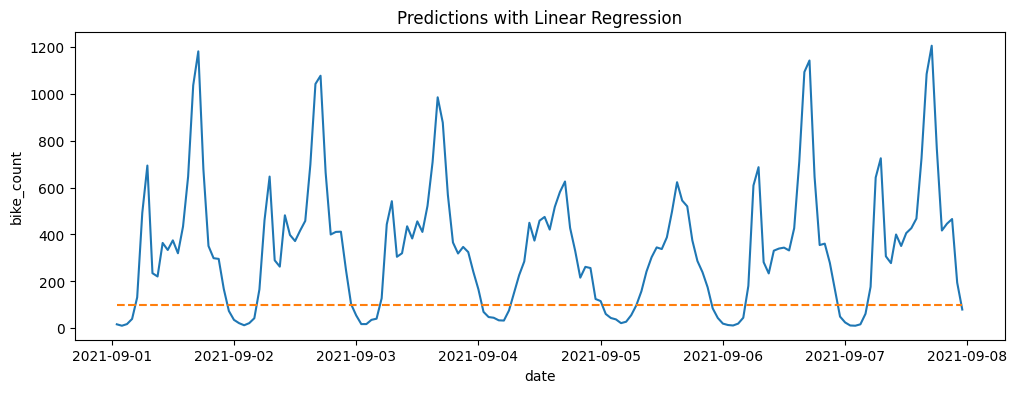

In [22]:
fig, ax = plt.subplots(figsize=(12, 4))

sns.lineplot(df_vis, x="date", y="bike_count", ax=ax)
sns.lineplot(df_vis, x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Linear Regression")
ax.set_ylabel("bike_count")

plt.show()

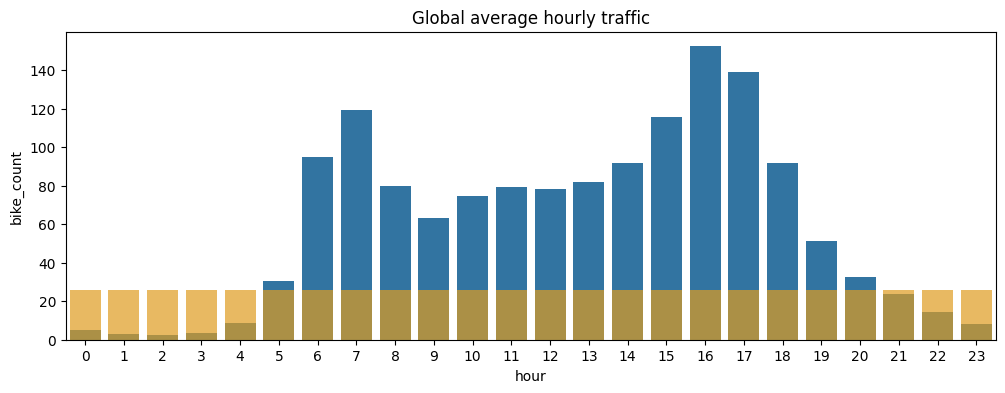

In [23]:
df_vis = X.copy()
df_vis["bike_count"] = np.exp(y) - 1
df_vis["bike_count (predicted)"] = np.exp(basic_linear_regressor.predict(X)) -1
df_vis["hour"] = df_vis["date"].dt.hour

avg_hourly_traffic = df_vis.groupby("hour").agg({"bike_count" : "mean"})
avg_hourly_traffic_pred = df_vis.groupby("hour").agg({"bike_count (predicted)" : "mean"})

fig, ax = plt.subplots(figsize=(12, 4))

sns.barplot(avg_hourly_traffic, x="hour", y="bike_count", ax=ax)
sns.barplot(avg_hourly_traffic_pred, x="hour", y="bike_count (predicted)", ax=ax, color="orange", alpha=0.7)
plt.title("Global average hourly traffic")
plt.show()

df_vis.drop(columns = "hour", inplace=True)

Let's encode the dates:

In [184]:
from sklearn.linear_model import LinearRegression

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("categorical", OneHotEncoder(handle_unknown="ignore"), categorical_columns)
    ]
)

pipeline = Pipeline(
    [
        ("dropper", column_dropper),
        ("vacation", vacation_encoder),
        ("date", date_encoder),
        ("preprocessor", preprocessor),
        ("linear_regressor", LinearRegression())
    ]
)

compute_score(pipeline, X_train, X_valid, y_train, y_valid)

np.float64(0.7289324114695552)

Encoding the dates with `OneHotEncoder` significantly improves the model. However, we can try another encoding, as using `OneHotEncoder` loses the natural order existing between dates.

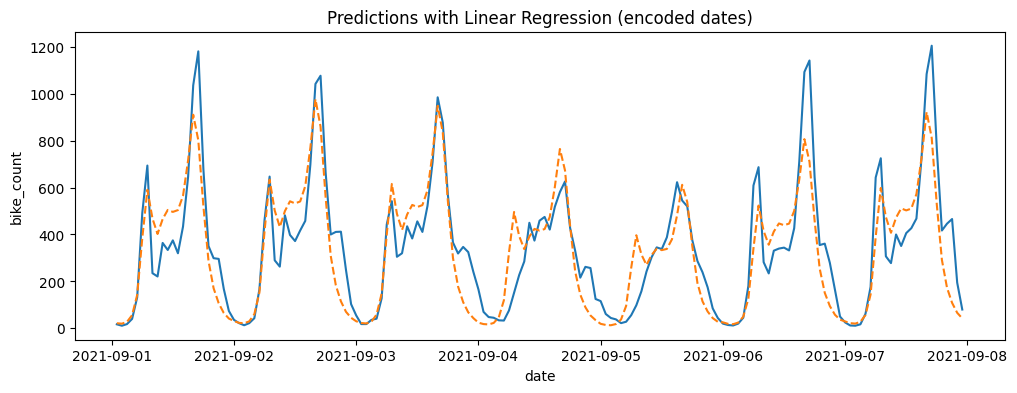

In [25]:
advanced_linear_regressor = pipeline.fit(X, y)

vis_mask = (
    (X["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X["date"] > pd.to_datetime("2021/09/01"))
    & (X["date"] < pd.to_datetime("2021/09/08"))
)

df_vis = X[vis_mask].copy()
y_vis = y[vis_mask]

df_vis["bike_count"] = np.exp(y_vis) - 1
df_vis["bike_count (predicted)"] = np.exp(advanced_linear_regressor.predict(X[vis_mask])) - 1

fig, ax = plt.subplots(figsize=(12, 4))

sns.lineplot(df_vis, x="date", y="bike_count", ax=ax)
sns.lineplot(df_vis, x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Linear Regression (encoded dates)")
ax.set_ylabel("bike_count")

plt.show()

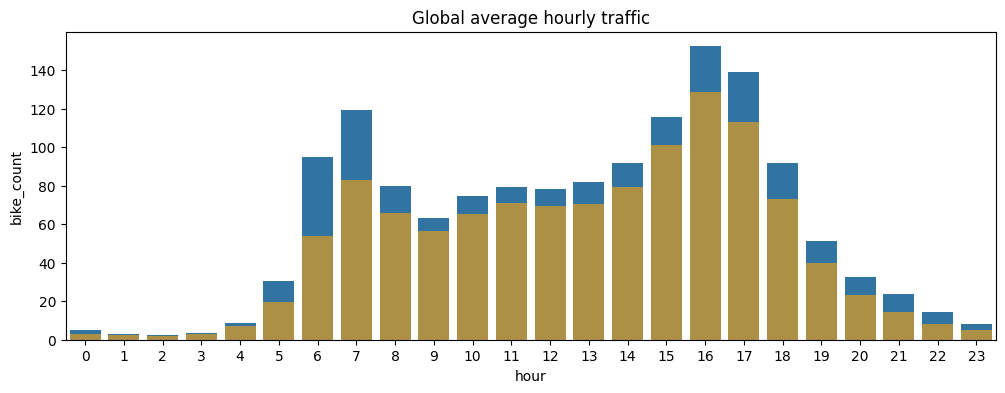

In [26]:
df_vis = X.copy()
df_vis["bike_count"] = np.exp(y) - 1
df_vis["bike_count (predicted)"] = np.exp(advanced_linear_regressor.predict(X)) -1
df_vis["hour"] = df_vis["date"].dt.hour

avg_hourly_traffic = df_vis.groupby("hour").agg({"bike_count" : "mean"})
avg_hourly_traffic_pred = df_vis.groupby("hour").agg({"bike_count (predicted)" : "mean"})

fig, ax = plt.subplots(figsize=(12, 4))

sns.barplot(avg_hourly_traffic, x="hour", y="bike_count", ax=ax)
sns.barplot(avg_hourly_traffic_pred, x="hour", y="bike_count (predicted)", ax=ax, color="orange", alpha=0.7)
plt.title("Global average hourly traffic")
plt.show()

df_vis.drop(columns = "hour", inplace=True)

#### With weather data

In [44]:
from sklearn.linear_model import LinearRegression

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("weather numerical", StandardScaler(), weather_columns),
        ("categorical", OneHotEncoder(handle_unknown="ignore"), categorical_columns),
    ],
    remainder="passthrough"
)

pipeline = Pipeline(
    [
        ("dropper", column_dropper),
        ("vacation", vacation_encoder),
        ("weather merge", weather_merger_2),
        ("date", date_encoder),
        ("preprocessor", preprocessor),
        ("linear_regressor", LinearRegression())
    ]
)

compute_score(pipeline, X_train, X_valid, y_train, y_valid)

np.float64(1.0173890229416753)

In [209]:
enter_prepro = date_encoder.transform(vacation_encoder.transform(column_dropper.transform(X)))

This is slightly better than the same linear model without the weather data.

C:\Users\augus\AppData\Local\Temp\ipykernel_4936\1184704182.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_vis = X_with_weather_valid[vis_mask].copy()


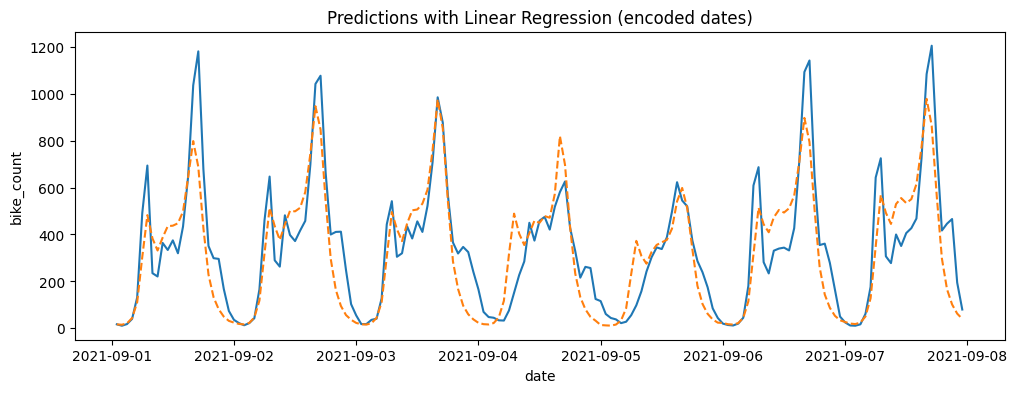

In [28]:
advanced_linear_regressor_with_weather = pipeline.fit(X_with_weather_train, y_with_weather_train)

vis_mask = (
    (X_with_weather["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X_with_weather["date"] > pd.to_datetime("2021/09/01"))
    & (X_with_weather["date"] < pd.to_datetime("2021/09/08"))
)

df_vis = X_with_weather_valid[vis_mask].copy()
y_vis = y_with_weather_valid[vis_mask]

df_vis["bike_count"] = np.exp(y_vis) - 1
df_vis["bike_count (predicted)"] = np.exp(advanced_linear_regressor_with_weather.predict(df_vis)) - 1

fig, ax = plt.subplots(figsize=(12, 4))

sns.lineplot(df_vis, x="date", y="bike_count", ax=ax)
sns.lineplot(df_vis, x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Linear Regression (encoded dates)")
ax.set_ylabel("bike_count")

plt.show()

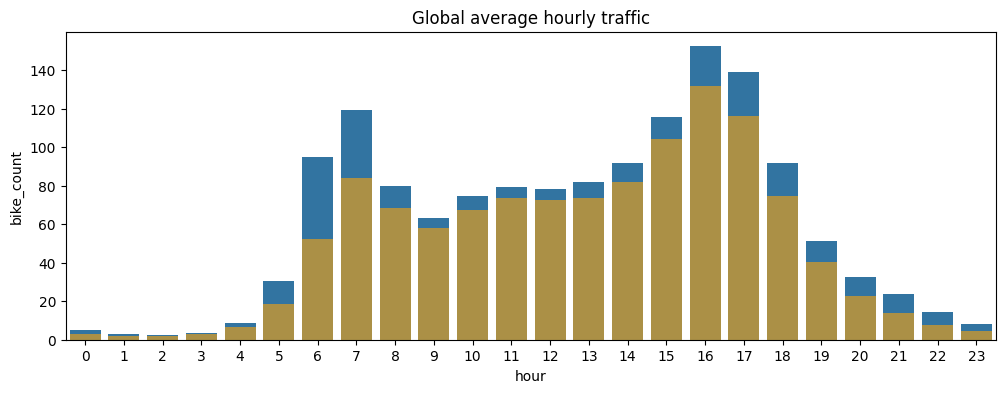

In [29]:
df_vis = X_with_weather.copy()
df_vis["bike_count"] = np.exp(y) - 1
df_vis["bike_count (predicted)"] = np.exp(advanced_linear_regressor_with_weather.predict(X_with_weather)) -1
df_vis["hour"] = df_vis["date"].dt.hour

avg_hourly_traffic = df_vis.groupby("hour").agg({"bike_count" : "mean"})
avg_hourly_traffic_pred = df_vis.groupby("hour").agg({"bike_count (predicted)" : "mean"})

fig, ax = plt.subplots(figsize=(12, 4))

sns.barplot(avg_hourly_traffic, x="hour", y="bike_count", ax=ax)
sns.barplot(avg_hourly_traffic_pred, x="hour", y="bike_count (predicted)", ax=ax, color="orange", alpha=0.7)
plt.title("Global average hourly traffic")
plt.show()

df_vis.drop(columns = "hour", inplace=True)

#### Ridge regression

In [30]:
from sklearn.linear_model import Ridge


preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("categorical", OneHotEncoder(handle_unknown="ignore"), categorical_columns)
    ]
)

pipeline = Pipeline(
    [
        ("dropper", column_dropper),
        ("date", date_encoder),
        ("preprocessor", preprocessor),
        ("linear_regressor", Ridge())
    ]
)

compute_score(pipeline, X_train, X_valid, y_train, y_valid)

np.float64(0.7289229697292228)

No significant change with a Ridge regression.

In [31]:
ridge_regressor = pipeline.fit(X, y)

vis_mask = (
    (X["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (X["date"] > pd.to_datetime("2021/09/01"))
    & (X["date"] < pd.to_datetime("2021/09/08"))
)

df_vis = X[vis_mask].copy()
y_vis = y[vis_mask]

df_vis["bike_count"] = np.exp(y_vis) - 1
df_vis["bike_count (predicted)"] = np.exp(ridge_regressor.predict(X[vis_mask])) - 1

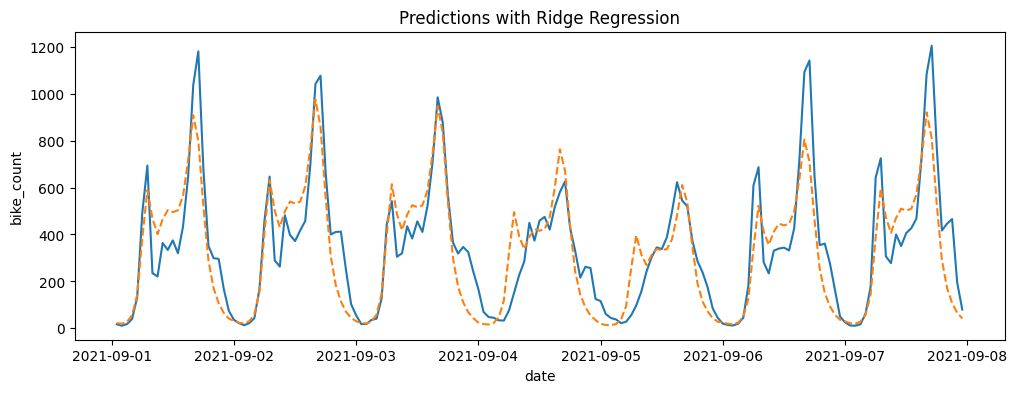

In [32]:
fig, ax = plt.subplots(figsize=(12, 4))

sns.lineplot(df_vis, x="date", y="bike_count", ax=ax)
sns.lineplot(df_vis, x="date", y="bike_count (predicted)", ax=ax, ls="--")
ax.set_title("Predictions with Ridge Regression")
ax.set_ylabel("bike_count")

plt.show()

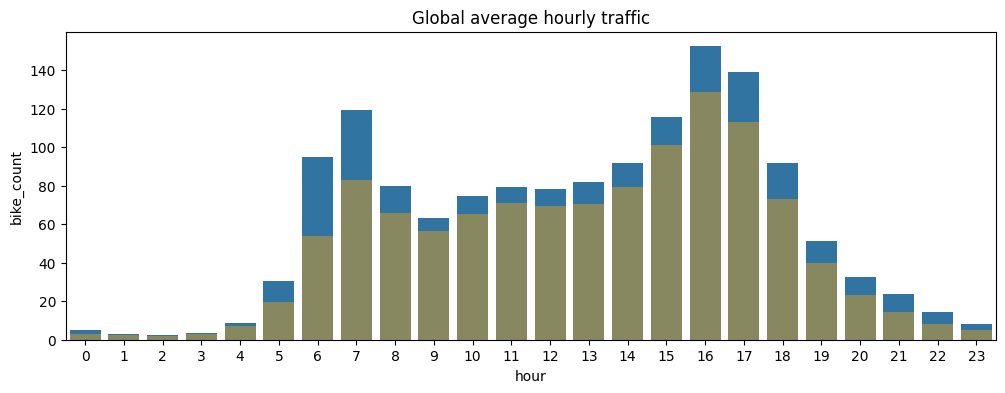

In [33]:
df_vis = X.copy()
df_vis["bike_count"] = np.exp(y) - 1
df_vis["bike_count (predicted)"] = np.exp(ridge_regressor.predict(X)) -1
df_vis["hour"] = df_vis["date"].dt.hour

avg_hourly_traffic = df_vis.groupby("hour").agg({"bike_count" : "mean"})
avg_hourly_traffic_pred = df_vis.groupby("hour").agg({"bike_count (predicted)" : "mean"})

fig, ax = plt.subplots(figsize=(12, 4))

sns.barplot(avg_hourly_traffic, x="hour", y="bike_count", ax=ax)
sns.barplot(avg_hourly_traffic_pred, x="hour", y="bike_count (predicted)", ax=ax, color="orange", alpha=0.5)
plt.title("Global average hourly traffic")
plt.show()

df_vis.drop(columns = "hour", inplace=True)

### Ensemble models

In [54]:
from sklearn.ensemble import RandomForestRegressor

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        # ("weather numerical", StandardScaler(), weather_columns),
        # ("categorical", OneHotEncoder(handle_unknown="ignore"), categorical_columns),
    ],
    remainder="passthrough"
)

pipeline = Pipeline(
    [
        ("dropper", column_dropper),
        ("vacation", vacation_encoder),
        ("weather merge", weather_merger_2),
        ("date", date_encoder),
        ("preprocessor", preprocessor),
        ("linear_regressor", RandomForestRegressor(n_estimators=37, max_depth=50, max_features="log2", n_jobs=-1))
    ]
)

compute_score(pipeline, X_train, X_valid, y_train, y_valid)

KeyboardInterrupt: 

#### Hyperparameter tuning

In [41]:
import optuna

# Define the objective function
def objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 10, 50)  # Range for number of trees
    max_depth = trial.suggest_int("max_depth", 5, 50)         # Range for tree depth
    
    # Define the pipeline with hyperparameters from the trial
    pipeline = Pipeline(
        [
            ("dropper", column_dropper),
            ("vacation", vacation_encoder),
            ("date", date_encoder),
            ("preprocessor", preprocessor),
            ("regressor", RandomForestRegressor(
                n_estimators=n_estimators,
                max_depth=max_depth,
                max_features="log2",
                n_jobs=-1,
                random_state=42  # For reproducibility
            ))
        ]
    )
    
    # Evaluate the pipeline using validation data
    score = compute_score(pipeline, X_with_weather_train, X_with_weather_valid, y_with_weather_train, y_with_weather_valid)
    return score  # Optuna minimizes the objective, so negate the RMSE score

# Create the study
study = optuna.create_study(direction="minimize")  # Minimize RMSE
study.optimize(objective, n_trials=50)  # Run for 50 trials


print("Best hyperparameters:", study.best_params)


[I 2024-12-11 09:40:18,817] A new study created in memory with name: no-name-86869e48-ef72-40d4-8d64-775c185c6ed5
[I 2024-12-11 09:40:29,281] Trial 0 finished with value: 0.903809359456317 and parameters: {'n_estimators': 42, 'max_depth': 19}. Best is trial 0 with value: 0.903809359456317.
[I 2024-12-11 09:40:41,548] Trial 1 finished with value: 0.7881837637733827 and parameters: {'n_estimators': 43, 'max_depth': 24}. Best is trial 1 with value: 0.7881837637733827.
[I 2024-12-11 09:40:57,701] Trial 2 finished with value: 0.5801163598076488 and parameters: {'n_estimators': 36, 'max_depth': 43}. Best is trial 2 with value: 0.5801163598076488.
[I 2024-12-11 09:41:05,365] Trial 3 finished with value: 0.5855650666070868 and parameters: {'n_estimators': 15, 'max_depth': 43}. Best is trial 2 with value: 0.5801163598076488.
[I 2024-12-11 09:41:19,753] Trial 4 finished with value: 0.6060528006213723 and parameters: {'n_estimators': 34, 'max_depth': 40}. Best is trial 2 with value: 0.58011635980

Best hyperparameters: {'n_estimators': 37, 'max_depth': 50}


### Boosting Models

In [36]:
from sklearn.ensemble import GradientBoostingRegressor

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        # ("weather numerical", StandardScaler(), numerical_weather_columns),
        # ("weather categorical", categorical_imputer, categorical_weather_columns),
        ("categorical", OneHotEncoder(handle_unknown="ignore"), categorical_columns),

    ]
)

pipeline = Pipeline(
    [
        ("dropper", column_dropper),
        ("vacation", vacation_encoder),
        ("date", date_encoder),
        ("preprocessor", preprocessor),
        ("linear_regressor", GradientBoostingRegressor())
    ]
)

compute_score(pipeline, X_train, X_valid, y_train, y_valid)

np.float64(0.7717784101515122)

In [49]:
from sklearn.ensemble import HistGradientBoostingRegressor

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        # ("weather numerical", StandardScaler(), weather_columns),
        ("categorical", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_columns),

    ]
)

pipeline = Pipeline(
    [
        ("dropper", column_dropper),
        ("vacation", vacation_encoder),
        # ("weather merge", weather_merger_2),
        ("date", date_encoder),
        ("preprocessor", preprocessor),
        ("linear_regressor", HistGradientBoostingRegressor())
    ]
)

compute_score(pipeline, X_train, X_valid, y_train, y_valid)

np.float64(0.6132060242948348)

In [44]:
import optuna

# Define the objective function
def objective(trial):
    # Suggest hyperparameters
    learning_rate = trial.suggest_float("learning_rate", 0.01, 1.)
    max_features = trial.suggest_float("max_features", 0.1, 1)
    max_iter = trial.suggest_int("max_iter", 5, 100)
    
    # Define the pipeline with hyperparameters from the trial
    pipeline = Pipeline(
        [
            ("dropper", column_dropper),
            ("vacation", vacation_encoder),
            ("date", date_encoder),
            ("preprocessor", preprocessor),
            ("regressor", HistGradientBoostingRegressor(learning_rate=learning_rate,
                                                        max_features=max_features,
                                                        max_iter=max_iter))
        ]
    )
    
    # Evaluate the pipeline using validation data
    score = compute_score(pipeline, X_with_weather_train, X_with_weather_valid, y_with_weather_train, y_with_weather_valid)
    return score  # Optuna minimizes the objective, so negate the RMSE score

# Create the study
study = optuna.create_study(direction="minimize")  # Minimize RMSE
study.optimize(objective, n_trials=50)  # Run for 50 trials


print("Best hyperparameters:", study.best_params)


[I 2024-12-11 10:27:23,109] A new study created in memory with name: no-name-bc2b6069-6319-45f4-ab2f-938199085156
[I 2024-12-11 10:27:34,651] Trial 0 finished with value: 0.5213241498310497 and parameters: {'learning_rate': 0.7525752486833127, 'max_features': 0.41777509709897054, 'max_iter': 74}. Best is trial 0 with value: 0.5213241498310497.
[I 2024-12-11 10:27:49,173] Trial 1 finished with value: 0.5467364912249886 and parameters: {'learning_rate': 0.2813954685402825, 'max_features': 0.546471972748741, 'max_iter': 97}. Best is trial 0 with value: 0.5213241498310497.
[I 2024-12-11 10:28:00,353] Trial 2 finished with value: 0.5068796481670526 and parameters: {'learning_rate': 0.8552072751492313, 'max_features': 0.6169956304940727, 'max_iter': 79}. Best is trial 2 with value: 0.5068796481670526.
[I 2024-12-11 10:28:10,706] Trial 3 finished with value: 0.5242842661913323 and parameters: {'learning_rate': 0.8039507011743439, 'max_features': 0.569648181286146, 'max_iter': 66}. Best is tri

Best hyperparameters: {'learning_rate': 0.9159159409124134, 'max_features': 0.9632270878222445, 'max_iter': 98}


In [113]:
from sklearn.ensemble import HistGradientBoostingRegressor

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        ("weather numerical", StandardScaler(), numerical_weather_columns),
        # ("weather categorical", categorical_imputer, categorical_weather_columns),
        ("categorical", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_columns),

    ]
)

pipeline = Pipeline(
    [
        ("dropper", column_dropper),
        ("vacation", vacation_encoder),
        ("date", date_encoder),
        ("preprocessor", preprocessor),
        ("linear_regressor", HistGradientBoostingRegressor(learning_rate=0.9159159409124134,
                                                           max_features=0.9632270878222445,
                                                           max_iter=98))
    ]
)

pipeline.fit(X_with_weather, y_with_weather)

Pipeline(steps=[('dropper',
                 FunctionTransformer(func=<function drop_columns at 0x00000255D8F0F880>)),
                ('vacation',
                 FunctionTransformer(func=<function encode_vacation at 0x00000255D79B3D80>)),
                ('date',
                 FunctionTransformer(func=<function encode_dates at 0x00000255D8F0F7E0>)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('weather numerical',
                                                  StandardScaler(),
                                                  ['U', 'FF', 'RR1', 'T']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['counter_id', 'site_id'])])),
                ('linear_regressor',
                 HistGradientBoostingRegressor(learning_rate=0.9159159409124134,
                                               max_features=0.9632270878222445,
                                               max_iter=98))])

In [114]:
root_mean_squared_error(y_with_weather_valid, pipeline.predict(X_with_weather_valid))

np.float64(0.4279537566945882)

In [115]:
kaggle_prediction(pipeline, "../prediction_csvs/pred_HistGB.csv", test_with_weather)

### XGBoost

In [ ]:
from xgboost import XGBRegressor


preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
        # ("weather numerical", StandardScaler(), numerical_weather_columns),
        # ("categorical", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_columns),
    ],
    remainder="passthrough"
)

pipeline = Pipeline(
    [
        ("dropper", column_dropper),
        ("vacation", vacation_encoder),
        ("date", date_encoder),
        ("preprocessor", preprocessor),
        ("linear_regressor", XGBRegressor(n_estimators=350, 
                                          learning_rate=0.1, 
                                          max_depth=20, 
                                          random_state=42, 
                                          objective='reg:squarederror'))
    ]
)

compute_score(pipeline, X_train, X_valid, y_train, y_valid)

KeyboardInterrupt: 

In [56]:
pipeline.fit(X, y)

c:\Users\augus\.virtualenvs\Python_classes-9Axu7pbz\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('dropper',
                 FunctionTransformer(func=<function drop_columns at 0x00000187AB593560>)),
                ('vacation',
                 FunctionTransformer(func=<function encode_vacation at 0x00000187AB593920>)),
                ('date',
                 FunctionTransformer(func=<function encode_dates at 0x00000187898F6660>)),
                ('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('date',
                                                  OneHotEnco...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=10, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=350, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])